<a href="https://colab.research.google.com/github/Gabor132/QuarantineSportsClassifier/blob/master/src/QuarantineSportsTrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quarantine Sports Classifier Training

## Imports

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import model_from_json


Using TensorFlow backend.


## Constants

In [0]:
learning_rate = 0.01
testing_data_percentage = 0.2
nr_of_frames_per_sequence = 15
nr_of_keypoints = 25
nr_of_values_per_keypoint = 3

all_files_names = ["video1.json", "video2.json", "video3.json"]

# Dataset paths
DRAGOS_COLAB_DATASET_PATH = "/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/"
LOCAL_DATASET_PATH = "../datasets/"

# Model paths
DRAGOS_COLAB_MODEL_PATH = "/content/drive/My Drive/QuarantineSportsDatasets/Model/"
LOCAL_MODEL_PATH = "../"

In [0]:
current_path = DRAGOS_COLAB_DATASET_PATH
current_model_path = DRAGOS_COLAB_MODEL_PATH

In [4]:
dataset_paths = []
for path in all_files_names:
  dataset_path = current_path + path
  dataset_paths.append(dataset_path)

print("All files found: {}".format(dataset_paths))

All files found: ['/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/video1.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/video2.json', '/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/video3.json']


## Load Datasets and create X and Y

## Important to know

1.   Out of open pose we extract for all frames all the 25 keypoints (each keypoint contains the X, Y and score)
2.   The Category exists per frame and is 0/1 as in Wrong/Correct as in Not a Push-Up Frame/Is a Push Up Frame


In [5]:
y_total = None
x_total = None
for (index, path) in enumerate(dataset_paths):
  print("For file at {}".format(path))
  df = pd.read_json(path)
  keypoints = df['Keypoints'].values
  file_y = df['Category'].values
  file_x = []
  for k in keypoints:
      if k != None:
          newK = np.reshape(np.asarray(k), (25,3))
          file_x.append(newK)
      else:
          file_x.append(np.reshape(np.zeros(75), (25,3)))
  file_x = np.array(file_x)
  print("X: {} and Y: {}".format(file_x.shape, file_y.shape))
  if np.all(x_total == None):
    x_total = file_x
  else:
    x_total = np.vstack((x_total, file_x))
  if np.all(y_total == None):
    y_total = file_y
  else:
    y_total = np.hstack((y_total, file_y))
print("Total X: {}".format(x_total.shape))
print("Total Y: {}".format(y_total.shape))

For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/video1.json
X: (270, 25, 3) and Y: (270,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/video2.json
X: (2317, 25, 3) and Y: (2317,)
For file at /content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/video3.json
X: (140, 25, 3) and Y: (140,)
Total X: (2727, 25, 3)
Total Y: (2727,)


## Splitting the dataset into categories (wrong and correct)

In [0]:
# Get Indexes
y_wrong_index = np.where(y_total == 0)
y_correct_index = np.where(y_total == 1)
# Get Values
x_wrong = x_total[y_wrong_index]
y_wrong = y_total[y_wrong_index]
x_correct = x_total[y_correct_index]
y_correct = y_total[y_correct_index]


## Further splitting the frames into sequences

In [7]:
print("Initial shapes")
print("y_wrong: {}".format(y_wrong.shape))
print("y_correct: {}".format(y_correct.shape))
print("x_wrong: {}".format(x_wrong.shape))
print("x_correct: {}".format(x_correct.shape))

class FrameSet:

  def __init__(self, x, y):
    self.x = x
    self.y = y

def get_maximum_number_of_usable_frames(a):
  divider = nr_of_frames_per_sequence
  i = 1
  while (divider * i) < len(a):
    i = i + 1
  return divider * (i-1)

def transform_y_into_frame_sets(a):
  number_of_sets = get_maximum_number_of_usable_frames(a)
  print("Number of sets: {}".format(number_of_sets))
  new_y = None
  if np.any(a == 0):
    new_y = np.zeros((int) (number_of_sets / nr_of_frames_per_sequence))
  else:
    new_y = np.ones((int) (number_of_sets / nr_of_frames_per_sequence))
  return new_y

def transform_x_into_frame_sets(a):
  number_of_sets = get_maximum_number_of_usable_frames(a)
  print("Number of sets: {}".format(number_of_sets))
  sub_group_size = a[0:number_of_sets]
  return np.reshape(sub_group_size, ((int) (number_of_sets / nr_of_frames_per_sequence), nr_of_frames_per_sequence, nr_of_keypoints * nr_of_values_per_keypoint))

y_wrong = transform_y_into_frame_sets(y_wrong)
y_correct = transform_y_into_frame_sets(y_correct)
x_wrong = transform_x_into_frame_sets(x_wrong)
x_correct = transform_x_into_frame_sets(x_correct)
print("After reshaping")
print("y_wrong: {}".format(y_wrong.shape))
print("y_correct: {}".format(y_correct.shape))
print("x_wrong: {}".format(x_wrong.shape))
print("x_correct: {}".format(x_correct.shape))

Initial shapes
y_wrong: (2057,)
y_correct: (670,)
x_wrong: (2057, 25, 3)
x_correct: (670, 25, 3)
Number of sets: 2055
Number of sets: 660
Number of sets: 2055
Number of sets: 660
After reshaping
y_wrong: (137,)
y_correct: (44,)
x_wrong: (137, 15, 75)
x_correct: (44, 15, 75)


## Recompine all wrong and correct arrays

In [8]:
# Only stack them when they are not empty
x_processed = None
y_processed = None
x_processed = np.concatenate((x_correct, x_wrong))
y_processed = np.concatenate((y_correct, y_wrong))
y_processed = to_categorical(y_processed)
print(x_processed.shape)
print(y_processed.shape)

(181, 15, 75)
(181, 2)


## Finally, split them into training and testing datasets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_processed, y_processed, test_size=0.2)
print("Number of training Frame Sets {} and number of testing Frame sets {}".format(len(x_train), len(x_test)))

Number of training Frame Sets 144 and number of testing Frame sets 37


## Loading of Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15)                5460      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 32        
Total params: 5,492
Trainable params: 5,492
Non-trainable params: 0
_________________________________________________________________


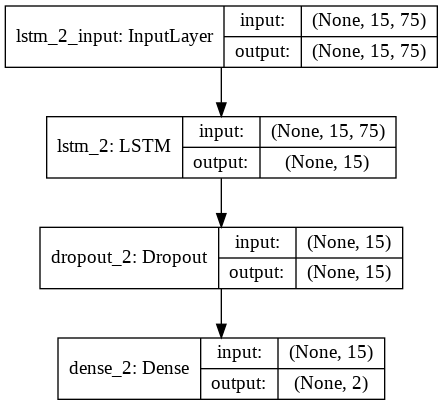

In [10]:
# load json and create model
json_file = open(current_model_path + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),loss='categorical_crossentropy',
              metrics=[keras.metrics.categorical_crossentropy])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
print("\n# Training")
model.fit(x_train, y_train, epochs=10, batch_size=15, verbose=1)



# Training
Epoch 1/10
144/144 [==============================] - 0s 3ms/step - loss: 0.5203 - categorical_crossentropy: 0.5203
Epoch 2/10
144/144 [==============================] - 0s 555us/step - loss: 0.4243 - categorical_crossentropy: 0.4243
Epoch 3/10
144/144 [==============================] - 0s 517us/step - loss: 0.3774 - categorical_crossentropy: 0.3774
Epoch 4/10
144/144 [==============================] - 0s 524us/step - loss: 0.2980 - categorical_crossentropy: 0.2980
Epoch 5/10
144/144 [==============================] - 0s 573us/step - loss: 0.3017 - categorical_crossentropy: 0.3017
Epoch 6/10
144/144 [==============================] - 0s 505us/step - loss: 0.2539 - categorical_crossentropy: 0.2539
Epoch 7/10
144/144 [==============================] - 0s 509us/step - loss: 0.2650 - categorical_crossentropy: 0.2650
Epoch 8/10
144/144 [==============================] - 0s 532us/step - loss: 0.1952 - categorical_crossentropy: 0.1952
Epoch 9/10
144/144 [==========================

In [12]:
print('\n# Evaluate')
result = model.evaluate(x_test, y_test, batch_size=1, verbose=1)
print(result)
dict(zip(model.metrics_names, result))


# Evaluate
37/37 [==============================] - 0s 3ms/step
[0.15576903310579224, 0.15576902031898499]


{'categorical_crossentropy': 0.15576902031898499, 'loss': 0.15576903310579224}

In [13]:
predict = model.predict(x_test)
for (index, p) in enumerate(predict):
  p_category = None
  if p[0] >= p[1]:
    p_category = 0
  else:
    p_category = 1
  e_category = None
  if y_test[index][0] >= y_test[index][1]:
    e_category = 0
  else:
    e_category = 1
  print("Predicted {} and expected {}".format(p_category, e_category))

Predicted 1 and expected 1
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 1 and expected 1
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 1 and expected 1
Predicted 0 and expected 0
Predicted 1 and expected 1
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 1 and expected 0
Predicted 1 and expected 1
Predicted 1 and expected 1
Predicted 0 and expected 0
Predicted 1 and expected 1
Predicted 1 and expected 1
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0
Predicted 0 and expected 0


## Finished